## Compressed Sensing

In [1]:
import numpy as np
from numpy.fft import *
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import pywt

# Load Image
m = loadmat('SUBMIT/M.mat')['M']

*Here we load the required packages and data from .mat files.*

### Assignment a
(4 marks) Generate a random undersampling pattern ($U_R$) and a variable density random undersampling pattern ($U_{VDR}$), both with acceleration factor of 4. Each sampling pattern must be a matrix with 1s in the sampled positions and 0s in the remaining ones. Obtain the corresponding PSFs and compare them. Obtained the aliased images as a result of undersampling with the generated patterns. For this you should use:
$$b=F^{-1}UFm$$
where m is the fully sampled image, U is the corresponding undersampling pattern, F is the Fourier transform and b is the aliased image. Depict the aliased images for the different undersampling patterns and compare against the fully sampled image.

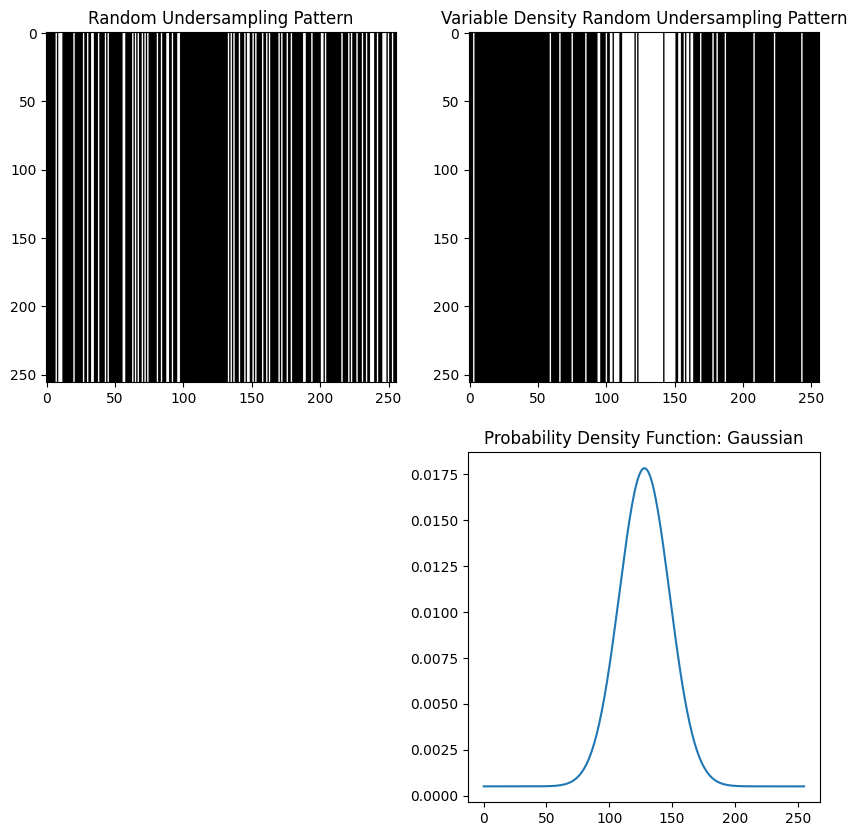

In [2]:
UR = np.zeros_like(m)
UVDR = np.zeros_like(m)

UR[:, np.random.choice(256, 256//4, replace=False)] = 1
sigma = 2e1
bias = 3e-2
p = np.exp(-(np.arange(256)-128)**2/(2*sigma**2))+bias
p /= np.sum(p)
UVDR[:, np.random.choice(256, 256//4, replace=False, p=p)] = 1

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(UR, cmap='gray')
plt.title("Random Undersampling Pattern")
plt.subplot(2, 2, 2)
plt.imshow(UVDR, cmap='gray')
plt.title("Variable Density Random Undersampling Pattern")
plt.subplot(2, 2, 4)
plt.title("Probability Density Function: Gaussian")
plt.plot(p)
plt.show()

*Two types of random undersampling patterns were generated, one with uniform random sampling (UR) and another one with variable density sampling (UVDR). The probablity density function (PDF) for the UVDR follows a normalized gaussian distribution with standard deviation of 2 and bias of 3e-2.*

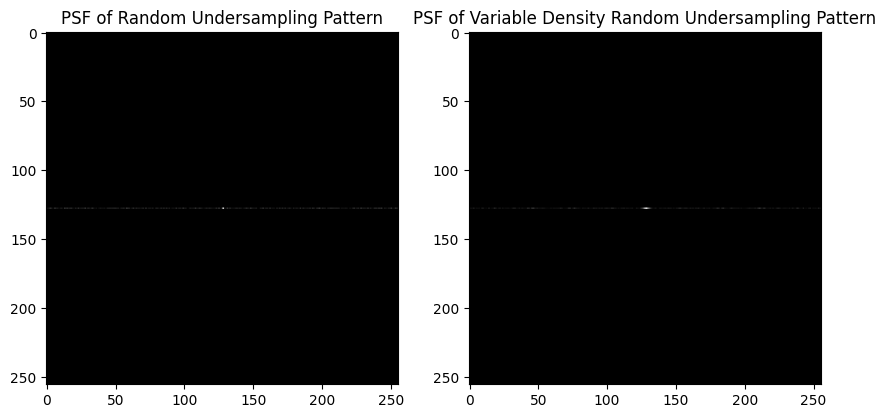

In [3]:
PSF_UR = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(UR)))
PSF_UVDR = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(UVDR)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(PSF_UR), cmap='gray')
plt.title("PSF of Random Undersampling Pattern")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(PSF_UVDR), cmap='gray')
plt.title("PSF of Variable Density Random Undersampling Pattern")
plt.show()

*The PSFs for the UR and UVDR patterns depicted above were obtained by applying iFFT to the sampling patterns. It's observed that the PSF for the UVDR pattern is more concentrated than the PSF for the UR pattern. This is due to the fact that the UVDR pattern has a higher probability of sampling the center of the image than the UR pattern.*

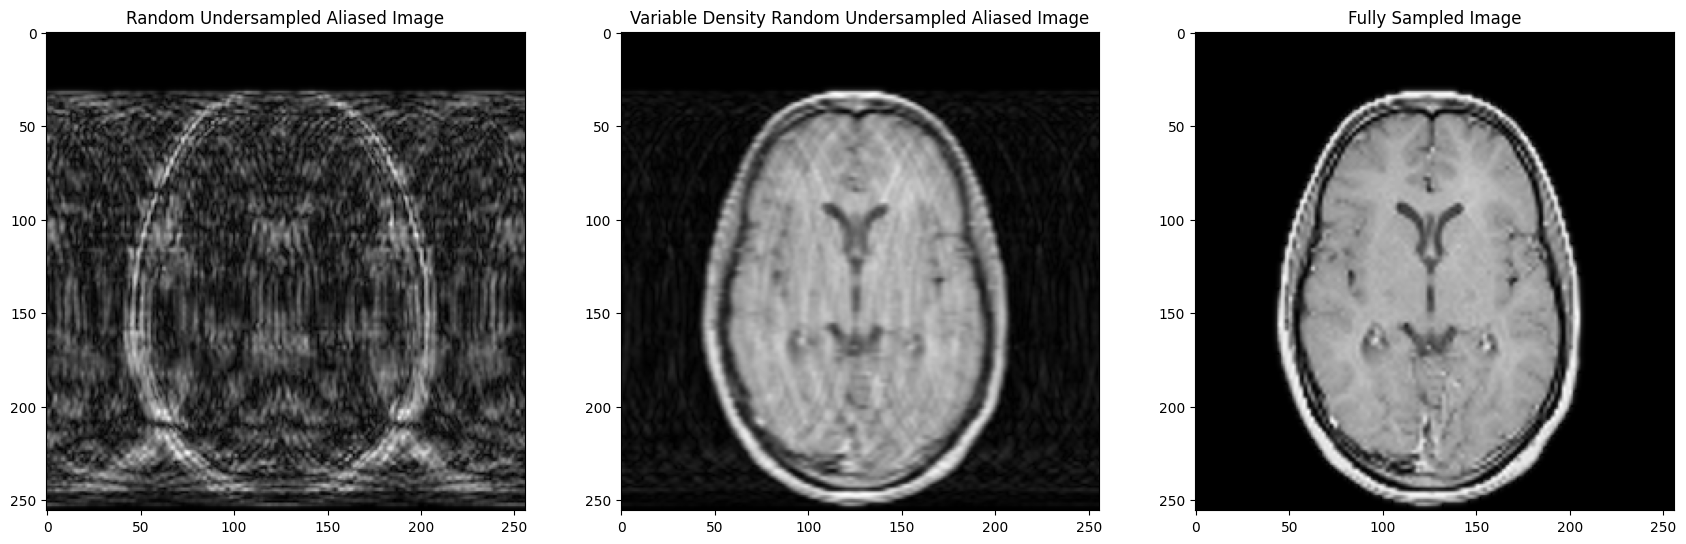

In [4]:
b_UR = fftshift(ifft2(ifftshift(UR*fftshift(fft2(ifftshift(m))))))
b_UVDR = fftshift(ifft2(ifftshift(UVDR*fftshift(fft2(ifftshift(m))))))

plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(b_UR), cmap='gray')
plt.title("Random Undersampled Aliased Image")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(b_UVDR), cmap='gray')
plt.title("Variable Density Random Undersampled Aliased Image")
plt.subplot(1, 3, 3)
plt.imshow(np.abs(m), cmap='gray')
plt.title("Fully Sampled Image")
plt.show()

*Above we compare the aliased images for the different undersampling patterns with the fully sampled image. It's apparent that the aliased image for the UR pattern is much more distorted than that for the UVDR pattern. This is due to the fact that UVDR undersampling pattern has a higher probability of sampling the lower frequencies components (center of the K-space) than the UR pattern.*

### Assignment b
(6 marks) Select one algorithm, among those available on internet (some of these are listed below, and you can use any other algorithms you found), to solve the Compressed Sensing problem with Total Variation regularization. Download the software and briefly describe each of the algorithms, you can use the test examples, usually provided together with these softwares, for your description.
Examples of algorithms:
+ L1-magic https://statweb.stanford.edu/~candes/software/l1magic/
+ NESTA https://statweb.stanford.edu/~candes/software/nesta/
+ TWIST http://www.lx.it.pt/~bioucas/TwIST/TwIST.htm
+ **SALSA http://cascais.lx.it.pt/~mafonso/salsa.html**

100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


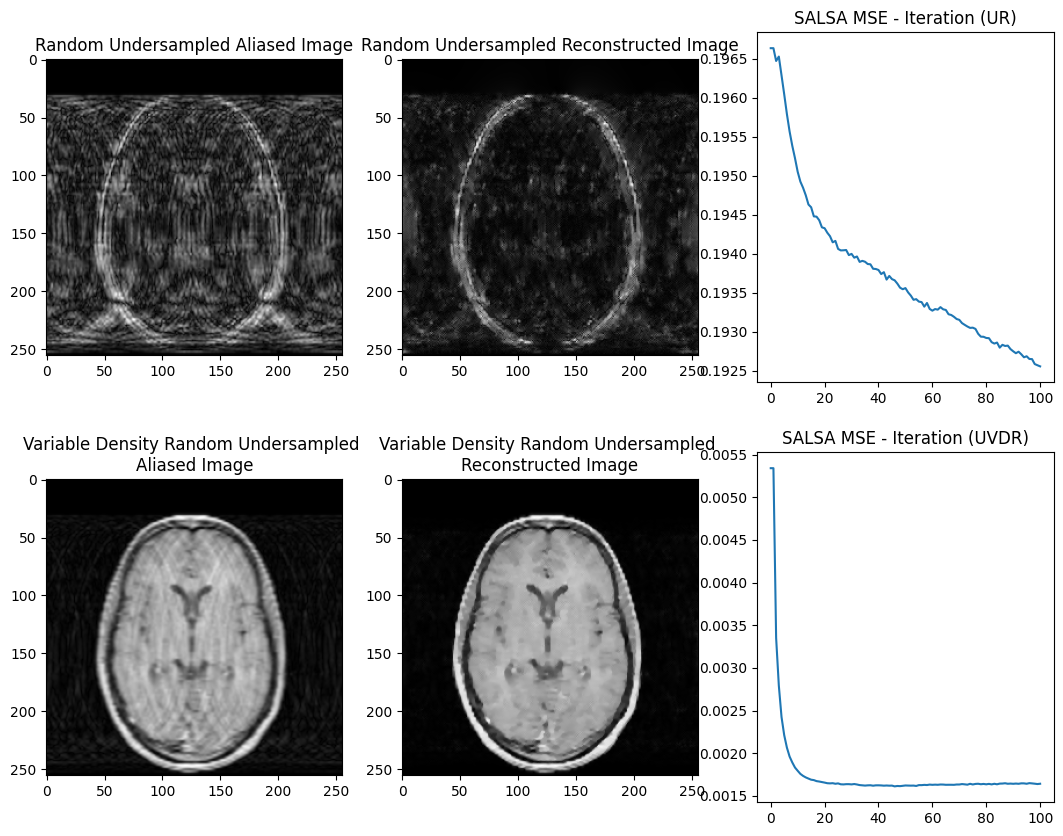

In [25]:
from utils import *

def PH(m):
    return m


def E(m, U=UVDR):
    return U*fftshift(fft2(ifftshift(m)))


def EH(b):
    return fftshift(ifft2(ifftshift(b), axes=(0, 1)))


def Psi(m, threshold):
    return denoiseTV(m, threshold, 20)


def invLS_UVDR(m, mu):
    return (m-(1/(1+mu))*EH(E(m, UVDR)))/mu


def invLS_UR(m, mu):
    return (m-(1/(1+mu))*EH(E(m, UR)))/mu

def SALSA(b, m_gold, EH, Psi, PH, invLS, threshold=0.5, mu=0.1, maxit=100):
    # Solving argmin_m||Em-b||_2^2 + lambda Phi(m)
    EHb = EH(b)
    m_ = EHb
    PHm = EHb
    u = PHm
    bu = np.zeros_like(u)
    threshold = threshold

    r = invLS(m_, mu)

    mse_history=[MSE(m_,m_gold)]
    for iteration in tqdm(range(maxit)):
        r = EHb + mu*(u+bu)
        m_ = invLS(r, mu)
        u = Psi(m_-bu, threshold)
        PHm = PH(m_)
        bu += (u-PHm)
        mse_history.append(MSE(m_,m_gold))
    return m_, mse_history

img_recon_UR, mse_UR = SALSA(E(m, UR), m, EH, Psi, PH, invLS_UR,
                     threshold=1e-1, mu=1e-5, maxit=100)
img_recon_UVDR, mse_UVDR = SALSA(E(m, UVDR), m, EH, Psi, PH,
                       invLS_UVDR, threshold=1e-1, mu=1e-5, maxit=100)

plt.figure(figsize=(13, 10))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(b_UR), cmap='gray')
plt.title("Random Undersampled Aliased Image")
plt.subplot(2, 3, 2)
plt.imshow(np.abs(img_recon_UR), cmap='gray')
plt.title("Random Undersampled Reconstructed Image")
plt.subplot(2,3,3)
plt.plot(mse_UR)
plt.title("SALSA MSE - Iteration (UR)")
plt.subplot(2, 3, 4)
plt.imshow(np.abs(b_UVDR), cmap='gray')
plt.title("Variable Density Random Undersampled \nAliased Image")
plt.subplot(2, 3, 5)
plt.imshow(np.abs(img_recon_UVDR), cmap='gray')
plt.title("Variable Density Random Undersampled \nReconstructed Image")
plt.subplot(2,3,6)
plt.plot(mse_UVDR)
plt.title("SALSA MSE - Iteration (UVDR)")
plt.show()

*Here we select the SALSA algorithm to solve the Compressed Sensing problem with Total Variation regularization. Due to the fact that official demo code for SALSA is written in Matlab, here we implement the algorithm in Python and apply it to our single coil CS reconstruction problem.*

*SALSA (split augmented Lagrangian shrinkage algorithm) algorithm is a fast and robust algorithm for solving formulations of a unconstrained optimization problem with a non-smooth regularization term. SALSA is based on variable splitting and augmented lagrangian methods.*
 
*The CS reconstruction problem is formulated as follows:*

$$\begin{aligned}
&\min\limits_{m,\theta} \|Em-b\|_2^2 + \lambda\Phi(\theta)\\
&\mathrm{s.t.}\quad m = \theta\\
\end{aligned} $$

Where $E=UF$ is the forward operator for image to k-space and undersampling, $b$ is the undersampled k-space data, $m$ is the image to be reconstructed, $\theta$ is the auxiliary variable introduced by the variable splitting method, $\Phi$ is the regularization term (Total Variation), and $\lambda$ is the regularization parameter.

*The algorithm is given by the following steps:*

*Initialization:*

$$\textit{choose}\quad \mu>0, m_0, \theta_0, d_0$$

$$\bar{b} = E^Hb$$

*Iteration*

$$\begin{aligned}
m'_k&=\theta_k+d_k\\
r_k&=\bar{b}+\mu m'_k\\
m_{k+1}&=\frac{1}{\mu}(I-E^HE)r_k\\
\theta'_k&=m_{k+1}-d_k\\
\theta_{k+1}&=\Psi_{r\Phi/\mu}(\theta'_k)\\
d_{k+1}&=d_k-\beta_{k+1}+\theta_{k+1}\\
\end{aligned}$$

*Where $\Psi_{r\Phi/\mu}$ denotes shrinkage/thresholding function for denoiseing the image*

### Assignment c 
(15 marks) Employ one of the algorithms to solve the undersampled problem in MRI for
both undersampling patterns, i.e.:
$$\min\limits_m \|Em-b\|_2^2+\lambda TV(m)$$
where E = UF corresponds to the forward sampling operator, with U the undersampling
operator, F the Fourier transform operator, B the undersampled k-space data and TV the
spatial finite difference operator. Show and compare your results for different values of the
parameter λ, including those with the near optimal parameters.

SALSA with UR


100%|██████████| 500/500 [00:47<00:00, 10.46it/s]


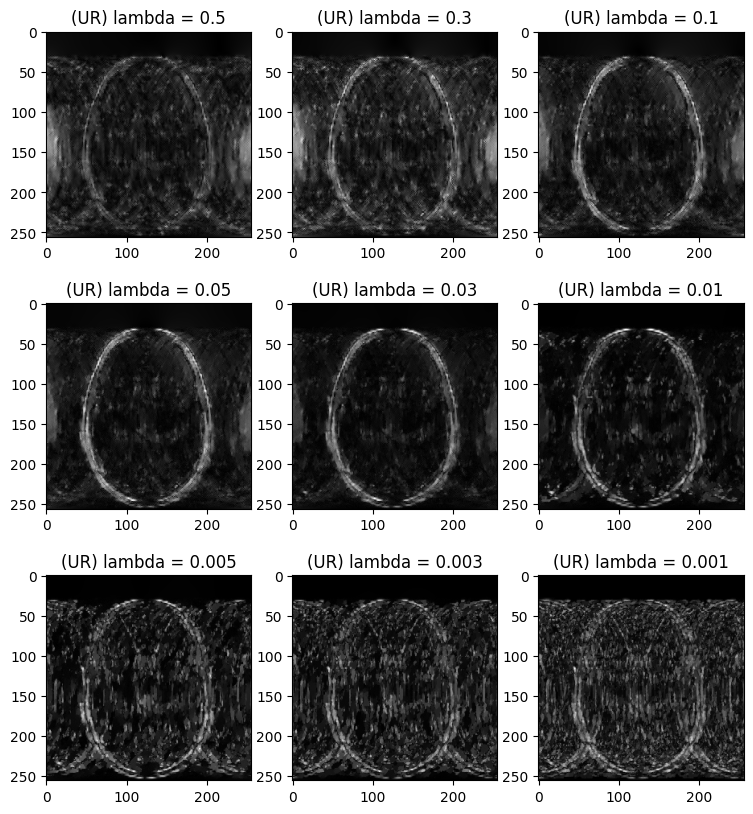

SALSA with UVDR


100%|██████████| 500/500 [00:53<00:00,  9.36it/s]


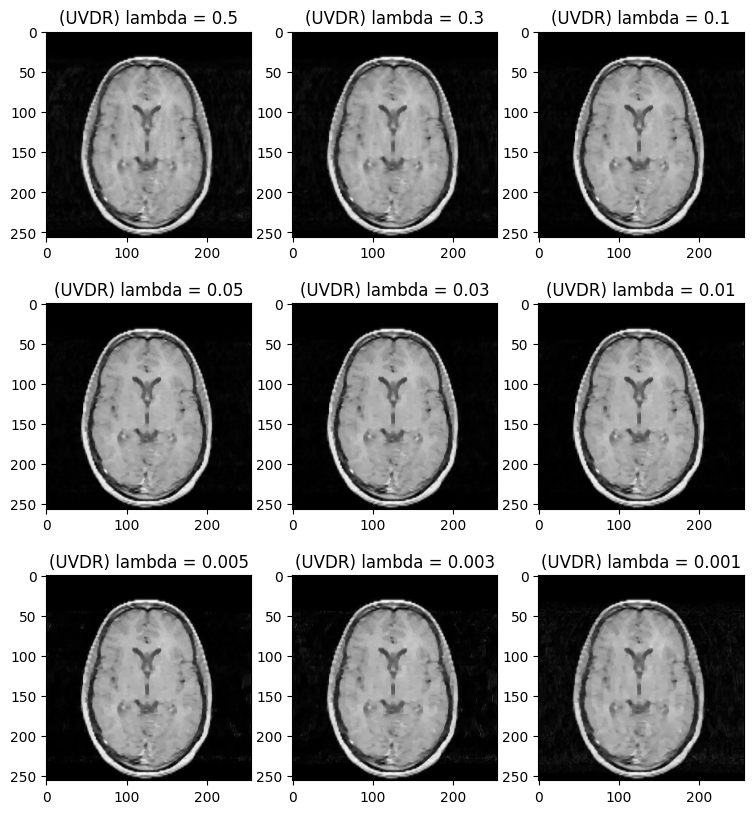

In [6]:
lambdas = [0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001]
mse_UR_list = []
mse_UVDR_list = []
plt.figure(figsize=(9, 10))
print("SALSA with UR")
for i, lm in enumerate(lambdas):
    mu = 1e-4
    img_recon_UR, mse_UR = SALSA(E(m, UR), m, EH, Psi, PH,
                           invLS_UR, threshold=lm, mu=mu, maxit=500)
    mse_UR_list.append(mse_UR)
    plt.subplot(3, 3, i+1)
    plt.imshow(np.abs(img_recon_UR), cmap='gray')
    plt.title("(UR) lambda = {}".format(lm, mu))
plt.show()
plt.figure(figsize=(9, 10))
print("SALSA with UVDR")
for i, lm in enumerate(lambdas):
    mu = 1e-4
    img_recon_UVDR, mse_UVDR = SALSA(E(m, UVDR), m, EH, Psi, PH,
                           invLS_UVDR, threshold=lm, mu=mu, maxit=500)
    mse_UVDR_list.append(mse_UVDR)
    plt.subplot(3, 3, i+1)
    plt.imshow(np.abs(img_recon_UVDR), cmap='gray')
    plt.title("(UVDR) lambda = {}".format(lm, mu))
plt.show()

*Above we depict the reconstructed images for the UR and UVDR undersampling patterns with different values of the regularization parameter $\lambda$. It's observed that the reconstructed images for the UVDR pattern are much better than those for the UR pattern. This is due to the fact that the UVDR pattern has a higher probability of sampling the lower frequencies components (center of the K-space) than the UR pattern.*

*With regards to the regularization parameter $\lambda$, it's apparent that the reconstructed image quality is highly dependent on $\lambda$. When $\lambda$ is too small or too large, aliasing artifacts couldn't be removed. For the UVDR pattern, the optimal value of $\lambda$ is around 0.03*

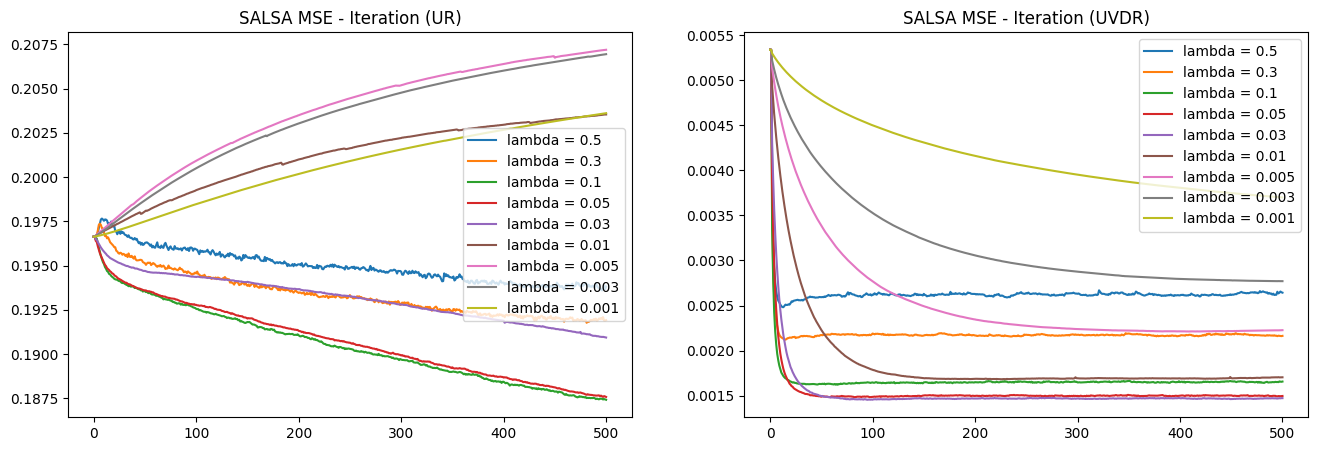

In [7]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
for i in range(len(lambdas)):
    plt.plot(mse_UR_list[i], label='lambda = {}'.format(lambdas[i]))
plt.title("SALSA MSE - Iteration (UR)")
plt.legend()
plt.subplot(1, 2, 2)
for i in range(len(lambdas)):
    plt.plot(mse_UVDR_list[i], label='lambda = {}'.format(lambdas[i]))
plt.title("SALSA MSE - Iteration (UVDR)")
plt.legend()
plt.show()

*MSE criteria is collected to analyze the reconstruction performance during SALSA iterations.*

*With regards to the UR pattern, considering that the image contrast for the undersampled image is extremely low (due to the fact that the UR pattern has a very low probability of sampling the lower frequencies components), MSE converges to a relatively high value (>1.8) after about 50 iterations for lambda range from 0.03 to 0.5, and for lambda below 0.3, MSE increases with iterations, which indicates that the reconstructed image quality is getting worse with iterations.*

*With regards to the UVDR pattern undersampling, aliasing artifacts are much less severe than those for the UR pattern. MSE converges to a extremely low value around 0.0015 after about 50 iterations for the optimal lambda value of 0.03. For lambda below 0.3, the steps required for MSE to converge to the optimal value increases with lambda.*

### Assignment d
(10 marks) Employ the iterative SENSE reconstruction implemented in Question 1 to
reconstruct the undersampled problem in MRI for both undersampling patterns
(considering a parallel imaging acquisition with coil maps given in Question 1). Compare
the algorithms and performance of iterative SENSE versus the Compressed Sensing (single
coil) method you investigated in (c). This comparison could consider e.g. usability, number
of iterations, convergence, root mean square error, computation time, etc.

100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


Text(0.5, 1.0, 'SENSE MSE - Iteration (UVDR)')

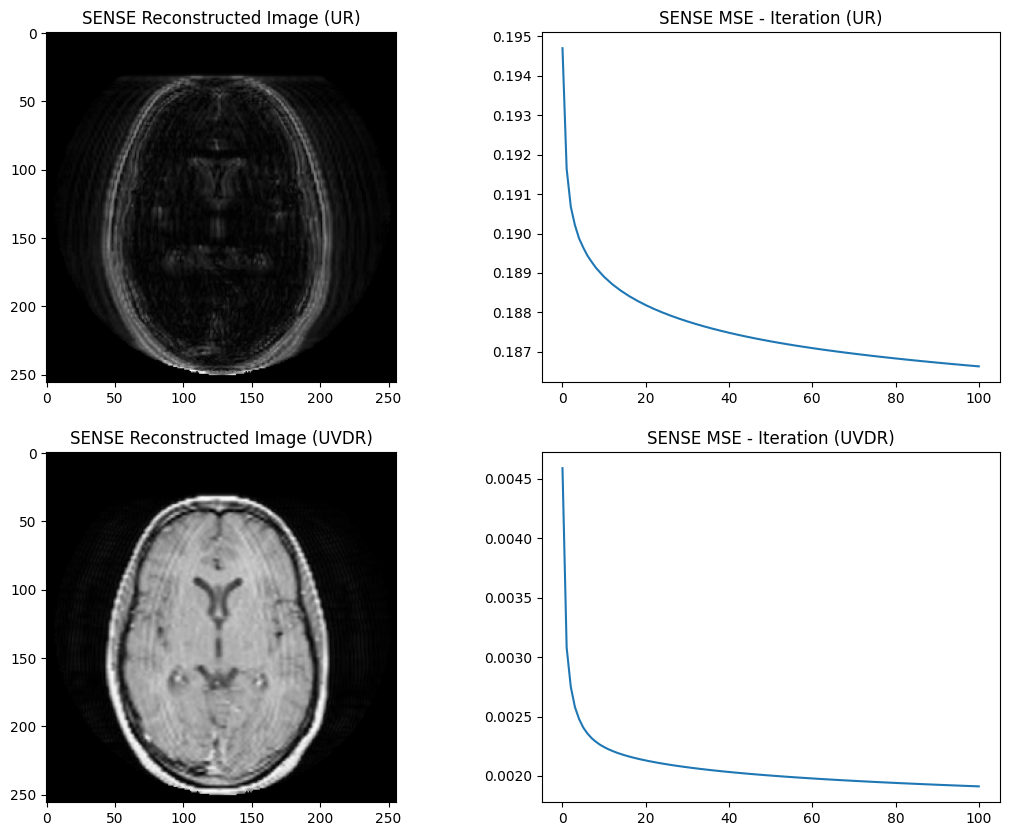

In [8]:
Nc = 8
C = loadmat('SUBMIT/C.mat')['C']
C_rss = np.sqrt(np.sum(np.abs(C)**2, axis=2))+1e-11
C /= C_rss[:, :, np.newaxis]
M = np.reshape(np.repeat(m, Nc, axis=1), C.shape)*C

def E_c(U, C, m):
    return U[:,:,np.newaxis]*fftshift(fft2(ifftshift(C*m[:, :, np.newaxis]), axes=(0, 1)))


def EH_c(C, b):
    return np.sum(fftshift(ifft2(ifftshift(b), axes=(0, 1)))
                 * C.conj(), axis=2)
    
                 
def Gradient_Descent(U, C, b, maxit):
    m_ = EH_c(C, b)
    r = m_-EH_c(C, E_c(U, C, m_))
    mse_history = [MSE(m, m_)]
    for i in tqdm(range(maxit)):
        a = np.abs(np.sum(r.conj()*r)/np.sum(r.conj()*EH_c(C, E_c(U, C, r))))
        m_ += a*r
        mse_history.append(MSE(m, m_))
        # Early Stopping
        err = np.sum(np.abs(r))
        if err < 1e-3:
            print('Converged at', i, 'with error', err)
            break
        r -= a*EH_c(C, E_c(U, C, r))
    return m_, mse_history

b_c_UR = E_c(UR, C, m)
b_c_UVDR = E_c(UVDR, C, m)

m_UR, mse_UR = Gradient_Descent(UR, C, b_c_UR, 100)
m_UVDR, mse_UVDR = Gradient_Descent(UVDR, C, b_c_UVDR, 100)

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.abs(m_UR), cmap='gray')
plt.title("SENSE Reconstructed Image (UR)")

plt.subplot(2, 2, 2)
plt.plot(mse_UR)
plt.title("SENSE MSE - Iteration (UR)")

plt.subplot(2, 2, 3)
plt.imshow(np.abs(m_UVDR), cmap='gray')
plt.title("SENSE Reconstructed Image (UVDR)")

plt.subplot(2, 2, 4)
plt.plot(mse_UVDR)
plt.title("SENSE MSE - Iteration (UVDR)")

*To compare the performance of iterative SENSE with SINA, we implement the iterative SENSE reconstruction for the UR and UVDR undersampling patterns with coil sensitivity. We analyze the algorithm performance from the following aspects:*

***Usability:*** *Iterative SENSE is much easier to implement than SALSA, it requires doesn't have any hyperparameters to tune, and it converges extremely fast. However, iterative SENSE requires coil sensitivity maps and parallel imaging with multiple coils. SALSA doesn't require coil sensitivity maps and it can be applied to single coil CS reconstruction.*

***Convergence:*** *Iterative SENSE converges extremely fast, it only requires about 20 iterations to converge. SALSA requires about 100 iterations to converge. But SALSA with optimal lambda value reaches a better reconstruction performance than iterative SENSE.*

***Image quality:*** *Although image quality could be assessed by MSE, some slight artifacts could be discovered by visual inspection. For the UVDR pattern, image reconstructed by iterative SENSE has vertical stripe artifacts, while image reconstructed by SALSA seems to be much smoother.*

***Computation time:*** *Iterative SENSE and SALSA are both extremely fast. Although SALSA requires more iterations, each iteration is faster than that for iterative SENSE. For the optimal lambda value, SALSA and iterative SENSE both requires about 10 seconds to converge for the UVDR pattern.*

### Assignment e
(15 marks) Considering now a parallel imaging acquisition with coil maps given in Question
1 for Compressed Sensing, modify the algorithm you investigated in (c) to combine
Compressed Sensing and Parallel Imaging, i.e. now E = UFC. Compare the performance of
this reconstruction with your results obtained in (d).

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Text(0.5, 1.0, 'SALSA coiled MSE - Iteration (UVDR)')

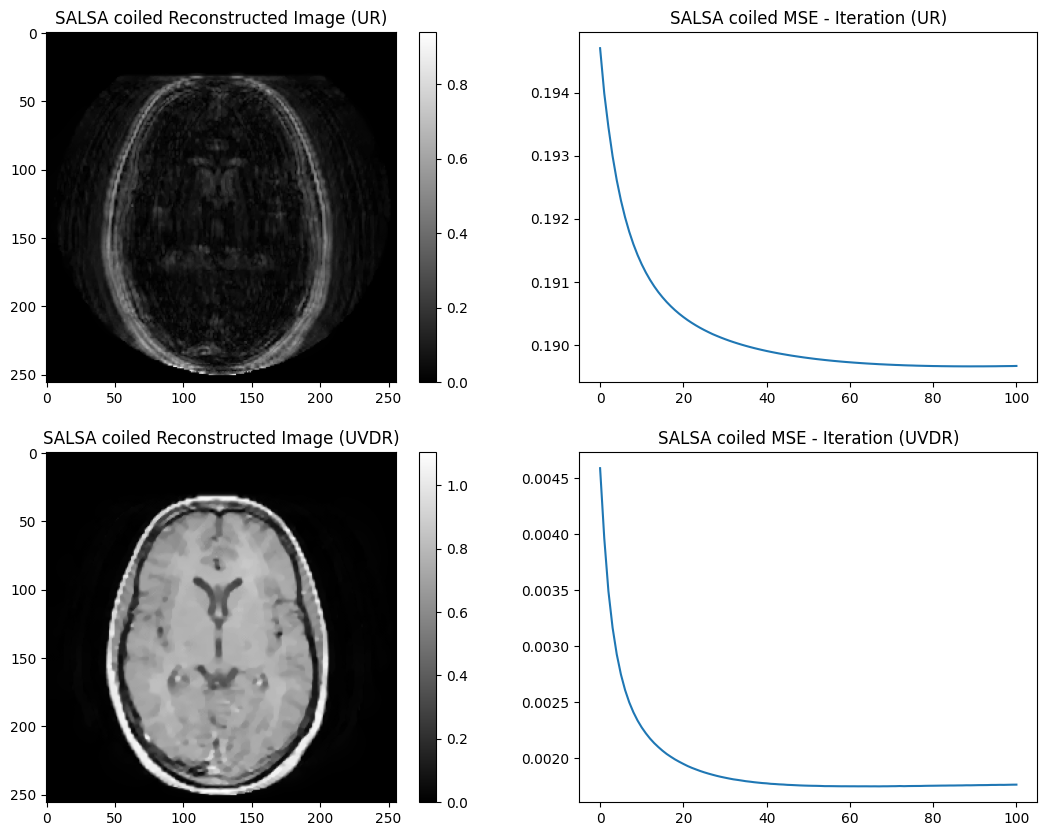

In [71]:
def SALSA_c(b, C, m_gold, EH_c, Psi, PH, invLS, threshold=0.5, mu=0.1, maxit=100):
    # SALSA for coil sensitivity (E = UFC)
    EHb = EH_c(C, b)
    m_ = EHb
    u = m_
    bu = np.zeros_like(u)

    r = invLS(m_, mu)

    mse_history=[MSE(m_,m_gold)]
    for iteration in tqdm(range(maxit)):
        r = EHb + mu*(u+bu)
        m_ = invLS(r, mu)
        u = Psi(m_-bu, threshold)
        bu += (u-m_)
        mse_history.append(MSE(m_,m_gold))
    return m_, mse_history

def E_c(U, C, m):
    return U[:,:,np.newaxis]*fftshift(fft2(ifftshift(C*m[:, :, np.newaxis]), axes=(0, 1)))


def EH_c(C, b):
    return np.sum(fftshift(ifft2(ifftshift(b), axes=(0, 1)))
                 * C.conj(), axis=2)

def invLS_c_UVDR(m, mu):
    return (m-1/(1+mu)*EH_c(C, E_c(UVDR, C, m)))/mu


def invLS_c_UR(m, mu):
    return (m-(1/(1+mu))*EH_c(C, E_c(UR, C, m)))/mu

img_recon_UR, mse_UR = SALSA_c(b_c_UR, C, m, EH_c, Psi, PH, 
                       invLS_c_UR, threshold=1e-3, mu=3, maxit=100)
img_recon_UVDR, mse_UVDR = SALSA_c(b_c_UVDR, C, m, EH_c, Psi, PH,
                       invLS_c_UVDR, threshold=5e-3, mu=2, maxit=100)

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.abs(img_recon_UR), cmap='gray')
plt.colorbar()
plt.title("SALSA coiled Reconstructed Image (UR)")

plt.subplot(2, 2, 2)
plt.plot(mse_UR)
plt.title("SALSA coiled MSE - Iteration (UR)")

plt.subplot(2, 2, 3)
plt.imshow(np.abs(img_recon_UVDR), cmap='gray')
plt.colorbar()
plt.title("SALSA coiled Reconstructed Image (UVDR)")

plt.subplot(2, 2, 4)
plt.plot(mse_UVDR)
plt.title("SALSA coiled MSE - Iteration (UVDR)")

*To combine Compressed Sensing and Parallel Imaging, we modify the SALSA algorithm by adding a coil sensitivity map to the forward operator $E=UFC$, and the corresponding inverse operator $E^H=C^HF^H$.*

*The reconstructed images and MSE-iteration curves for the UR and UVDR undersampling patterns are depicted above. In comparison with the single coil SALSA reconstruction, the multi-coil SALSA reconstruction converges much faster and reaches a better reconstruction performance. For the UVDR pattern, the multi-coil SALSA reconstruction reaches a MSE value of 0.0017 after about 20 iterations.*

*In comparison with the iterative SENSE reconstruction, the multi-coil SALSA reconstruction converges a little bit slower than the iterative SENSE reconstruction, but it reaches a lower MSE. Based on the MSE-iteration curves, the multi-coil SALSA reconstruction reaches a MSE value of 0.0017 after about 20 iterations, while the iterative SENSE reconstruction reaches a MSE value of 0.002 after about 20 iterations. Based on visual inspection, stripe artifacts are less significant for the multi-coil SALSA reconstruction than the iterative SENSE reconstruction.*